<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/Copy_of_Knn%2BINCE93_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
4/4 [==============================] - 33s 7s/step - loss: 0.6845 - accuracy: 0.6696 - val_loss: 0.6558 - val_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 29s 8s/step - loss: 0.5735 - accuracy: 0.7391 - val_loss: 0.6065 - val_accuracy: 0.6207
Epoch 3/10
4/4 [==============================] - 24s 7s/step - loss: 0.5094 - accuracy: 0.7565 - val_loss: 0.5714 - val_accuracy: 0.7241
Epoch 4/10
4/4 [==============================] - 24s 7s/step - loss: 0.4593 - accuracy: 0.7739 - val_loss: 0.5550 - val_accuracy: 0.6207
Epoch 5/10
4/4 [==============================] - 26s 6s/step - loss: 0.4249 - accuracy: 0.8000 - val_loss: 0.5298 - val_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 24s 7s/step - loss: 0.3902 - accuracy: 0.8174 - val_loss: 0.5068 - val_accuracy: 0.6897
Epoch 7/10
4/4 [==============================] - 23s 6s/step - loss: 0.3640 - accuracy: 0.8522 - val_loss:

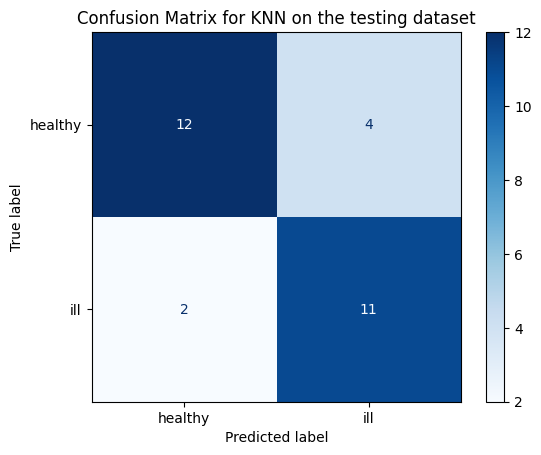

Classification Report for KNN on the training dataset:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93        56
           1       0.92      0.95      0.93        59

    accuracy                           0.93       115
   macro avg       0.93      0.93      0.93       115
weighted avg       0.93      0.93      0.93       115



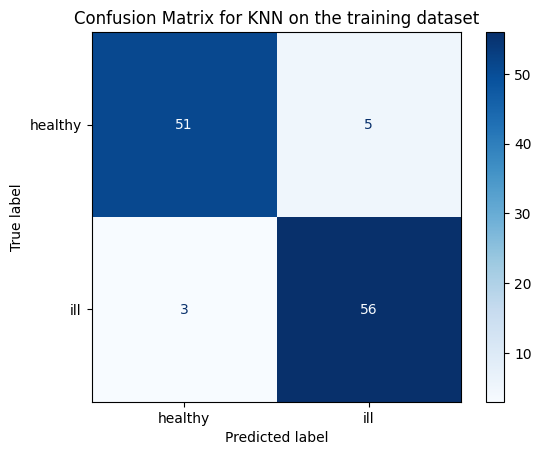

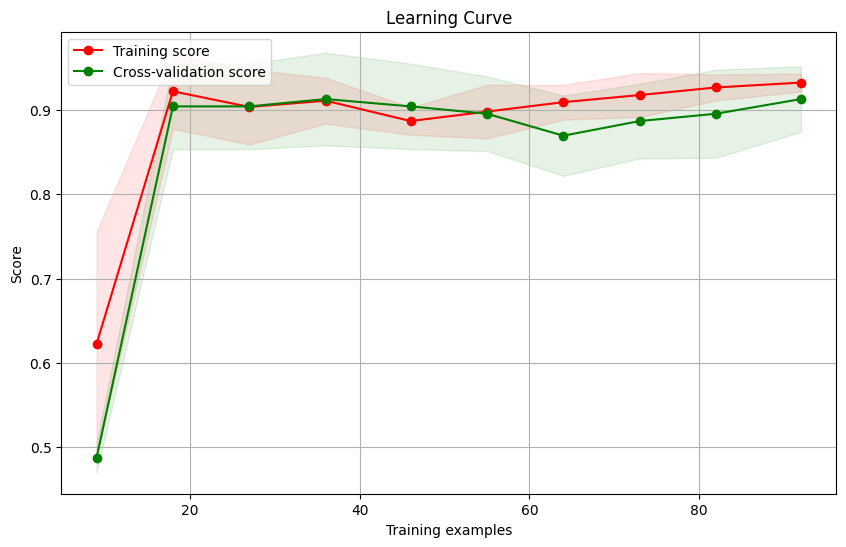

In [2]:
import os
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

seed = 42  # You can use any integer value as the seed
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.2, random_state=seed)

# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Define a range of hyperparameters to search over for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function for prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute neighbors
    'p': [1, 2]  # Power parameter for Minkowski distance
}

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Predict on the testing dataset using the best KNN classifier with PCA features
best_knn_classifier = grid_search.best_estimator_
y_test_pred = best_knn_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for KNN on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the testing dataset")
plt.show()

# Predict on the training dataset using the best KNN classifier with PCA features
y_train_pred = best_knn_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for KNN on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the training dataset")
plt.show()

from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()
